# 코로나 신규 확진자수 추이

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import matplotlib
from numpy import inf

matplotlib.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline

In [52]:
covid = pd.read_csv("C:/Users/wook/JW study/Bigcon/Data/Covid-19.csv")
covid.head()

,Date,Seoul,Daegu,Total
0,02-01,0,0,1
1,02-02,0,0,3
2,02-03,0,0,0
3,02-04,0,0,1
4,02-05,0,0,3


In [53]:
covid.Date = '2020-' + covid.Date
covid['Date'] = pd.to_datetime(covid.Date, format='%Y-%m-%d')
covid['WEEK_NUM'] = covid['Date'].dt.weekofyear

weekdays = {0:'월', 1:'화', 2:'수', 3:'목', 4:'금', 5:'토', 6:'일'}
covid['WEEKDAY'] = covid.Date.dt.dayofweek.apply(lambda x : weekdays.get(x))

covid.head()

,Date,Seoul,Daegu,Total,WEEK_NUM,WEEKDAY
0,2020-02-01,0,0,1,5,토
1,2020-02-02,0,0,3,5,일
2,2020-02-03,0,0,0,6,월
3,2020-02-04,0,0,1,6,화
4,2020-02-05,0,0,3,6,수


In [76]:
def graph_corona_time_plot(covid):
    ax = covid['Total '].plot(figsize=(16, 6))
    ax.axvline(x=20, color='r', linewidth=2, linestyle='--')
    plt.text(x=7, 
             y=covid['Total '].max()*0.9, 
             s='코로나 타격 \n{}주차 {}요일'.format(covid['WEEK_NUM'][20], covid['WEEKDAY'][20]), 
             fontsize=14)
    plt.title("코로나 신규확진자수 (한국)", fontsize=14)
    plt.show()

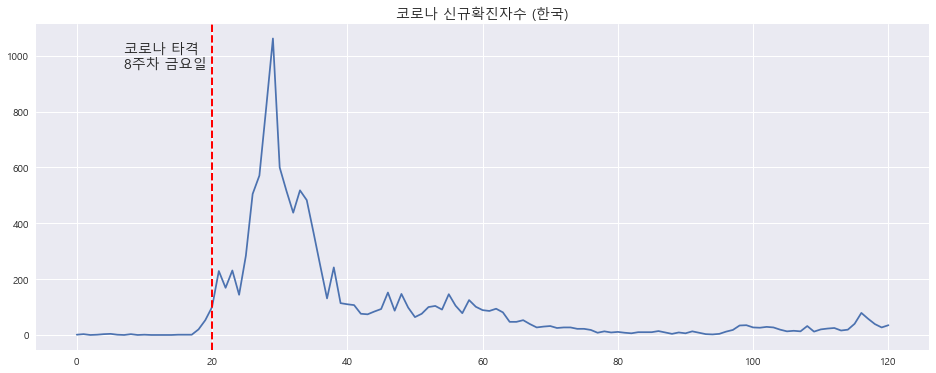

In [77]:
graph_corona_time_plot(covid)

# 업종 별 EDA

# __ __ __ __ __ __ __ __ __ __ __ __ __ __ __

In [4]:
offline = pd.read_csv("C:/Users/wook/JW study/Bigcon/Data/CARD_SPENDING_RESIDENT_KOR.csv")
offline.head()

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,AVG_AMT,YEAR,MONTH,DAY,YEAR_MONTH
0,20190201,대구 중구,동인동,숙박,F,25,11,595,54.090909,2019,2,1,201902
1,20190201,대구 중구,동인동,숙박,F,50,5,243,48.600000,2019,2,1,201902
2,20190201,대구 중구,동인동,숙박,F,55,5,27,5.400000,2019,2,1,201902
3,20190201,대구 중구,동인동,숙박,M,20,11,243,22.090909,2019,2,1,201902
4,20190201,대구 중구,동인동,숙박,M,25,11,433,39.363636,2019,2,1,201902


In [7]:
# 요일 계산 (dt.dayofweek를 통해 해당 날짜의 요일을 반환할 수 있음.)
weekdays = {0:'월', 1:'화', 2:'수', 3:'목', 4:'금', 5:'토', 6:'일'}
offline['STD_DD'] = pd.to_datetime(offline.STD_DD, format='%Y%m%d')
offline['WEEKDAY'] = offline.STD_DD.dt.dayofweek.apply(lambda x : '_'.join([str(x),weekdays.get(x)]))
offline.head()

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,AVG_AMT,YEAR,MONTH,DAY,YEAR_MONTH,WEEKDAY
0,2019-02-01,대구 중구,동인동,숙박,F,25,11,595,54.090909,2019,2,1,201902,4_금
1,2019-02-01,대구 중구,동인동,숙박,F,50,5,243,48.600000,2019,2,1,201902,4_금
2,2019-02-01,대구 중구,동인동,숙박,F,55,5,27,5.400000,2019,2,1,201902,4_금
3,2019-02-01,대구 중구,동인동,숙박,M,20,11,243,22.090909,2019,2,1,201902,4_금
4,2019-02-01,대구 중구,동인동,숙박,M,25,11,433,39.363636,2019,2,1,201902,4_금


In [11]:
# 주차 계산 (마찬가지로 dt.weekofyear을 통해 해당 날짜의 주차를 알 수 있음.)
offline['WEEK_NUM'] = offline['STD_DD'].dt.weekofyear
offline.head()

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,AVG_AMT,YEAR,MONTH,DAY,YEAR_MONTH,WEEKDAY,WEEK_NUM
0,2019-02-01,대구 중구,동인동,숙박,F,25,11,595,54.090909,2019,2,1,201902,4_금,5
1,2019-02-01,대구 중구,동인동,숙박,F,50,5,243,48.600000,2019,2,1,201902,4_금,5
2,2019-02-01,대구 중구,동인동,숙박,F,55,5,27,5.400000,2019,2,1,201902,4_금,5
3,2019-02-01,대구 중구,동인동,숙박,M,20,11,243,22.090909,2019,2,1,201902,4_금,5
4,2019-02-01,대구 중구,동인동,숙박,M,25,11,433,39.363636,2019,2,1,201902,4_금,5


In [14]:
print(set(offline['MCT_CAT_CD']))

{'서적문구', '의료기관', '가구', '신변잡화', '문화취미', '레저용품', '수리서비스', '숙박', '보건위생', '레저업소', '음료식품', '자동차 정비', '자동차판매', '유통업', '광학제품', '전기', '직물', '의복', '주방용구', '연료판매', '가전', '사무통신', '요식업소'}


# 특정 업종 선택 (사무통신)

## 1. 전년 대비 동월 비교

In [15]:
def graph_by_year_month_offline(category_name):
    # 카테고리에 속하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # YEAR, MONTH로 묶고 AMT, CNT 합 구하기
    category_df = category_df.groupby(['YEAR', 'MONTH'])[['USE_AMT', 'USE_CNT']].sum().reset_index()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    sns.barplot(x=category_df['MONTH'], y=category_df['USE_CNT'], hue='YEAR', data=category_df, ax=axes[0])
    sns.barplot(x=category_df['MONTH'], y=category_df['USE_AMT'], hue='YEAR', data=category_df, ax=axes[1])
    axes[0].set_title(category_name + "의 월별 소비횟수")
    axes[1].set_title(category_name + "의 월별 소비금액")

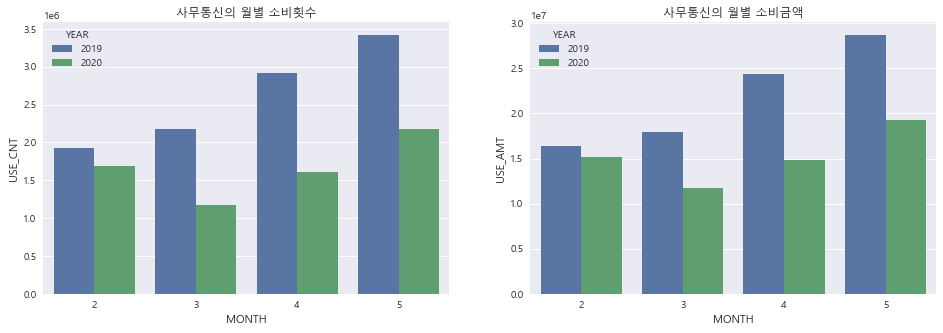

In [16]:
graph_by_year_month_offline("사무통신")

## 2. 연령 별로 시간에 따른 변화율 관찰

### (1) 19년과 20년의 월별 비중 변화

In [18]:
def graph_by_year_month_offline(category_name, hue_column):
    # 카테고리에 해당하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # YEAR_MONTH별로 CNT, AMT 합 구하기
    category_df = category_df.groupby(['YEAR_MONTH', hue_column])[['USE_CNT', 'USE_AMT']].sum().reset_index()
    # graph 화면을 2개의 row와 1개의 column으로 분할하기.
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))
    # 막대 그래프를 그릴 때, x축과 y축을 설정하고, hue는 분할 기준, ax는 그림의 위치
    sns.barplot(x='YEAR_MONTH', y='USE_CNT', hue=hue_column, data=category_df, ax=axes[0])
    sns.barplot(x='YEAR_MONTH', y='USE_AMT', hue=hue_column, data=category_df, ax=axes[1])
    # 그림에 제목을 달자.
    axes[0].set_title(category_name + "의 {}별 소비횟수".format(hue_column))
    axes[1].set_title(category_name + "의 {}별 소비금액".format(hue_column))
    # 범례를 추가하되, 위치까지 설정.
    axes[0].legend(loc='lower right')
    axes[1].legend(loc='lower right')
    # 수직라인을 그리되, x축의 위치 설정, 색깔, 선의 굵기, 선 스타일 설정.
    axes[0].axvline(x=3.5, color='r', linewidth=2, linestyle='--')
    axes[1].axvline(x=3.5, color='r', linewidth=2, linestyle='--')

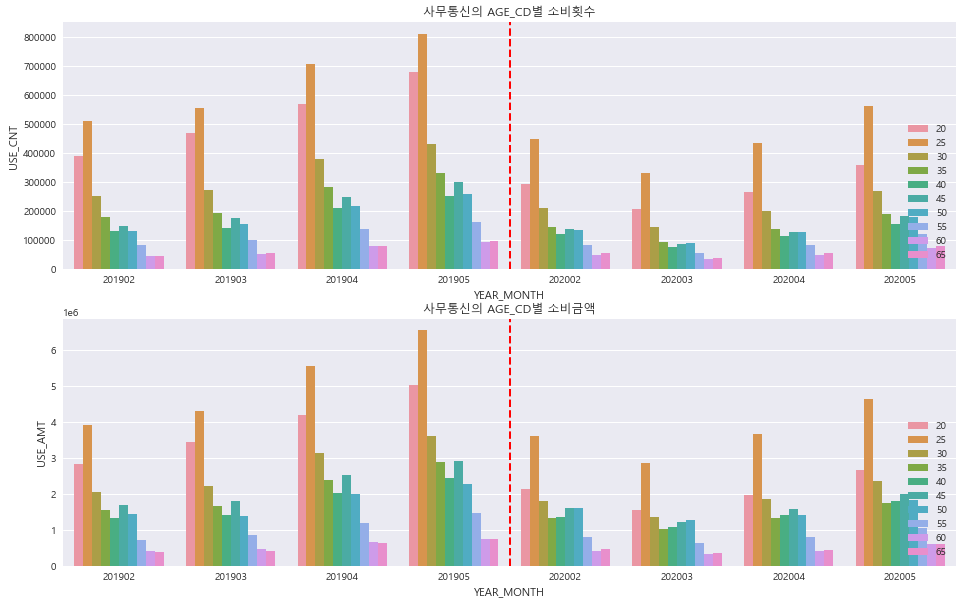

In [19]:
graph_by_year_month_offline("사무통신", "AGE_CD")

### (2) 19년과 20년의 주별 비중 변화

In [20]:
def graph_by_month_number_offline(category_name, hue_column):
    # 카테고리에 해당하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # 주차별로 CNT, AMT 합 구하기
    category_df = category_df.groupby(['YEAR', 'WEEK_NUM', hue_column])[['USE_CNT', 'USE_AMT']].sum().reset_index()
    df_2019 = category_df.query('YEAR==2019')
    df_2020 = category_df.query('YEAR==2020')
    
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16, 20))
    sns.barplot(x='WEEK_NUM', y='USE_CNT', hue=hue_column, data=df_2019, ax=axes[0])
    sns.barplot(x='WEEK_NUM', y='USE_CNT', hue=hue_column, data=df_2020, ax=axes[1])
    sns.barplot(x='WEEK_NUM', y='USE_AMT', hue=hue_column, data=df_2019, ax=axes[2])
    sns.barplot(x='WEEK_NUM', y='USE_AMT', hue=hue_column, data=df_2020, ax=axes[3])
    
    aggregate_columns = ['USE_CNT', 'USE_AMT']
    years = [2019, 2020]
    for i in [0, 1, 2, 3]:
        axes[i].set_title(category_name + "{}년의 {}별 {}".format(years[i%2], hue_column, aggregate_columns[i//2]))
        axes[i].legend(loc='lower right')
        axes[i].set_ylim([0, category_df[aggregate_columns[i//2]].max()*1.1])
        axes[i].axvline(x=2.5, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=6.5, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=14.5, color='g', linewidth=2, linestyle='--')
        axes[i].text(x=2.5, y=category_df[aggregate_columns[i//2]].max()*0.9, s="　코로나 확산기(8~11주)")
        axes[i].text(x=14.5, y=category_df[aggregate_columns[i//2]].max()*0.9, s="　재난지원금 지급주")

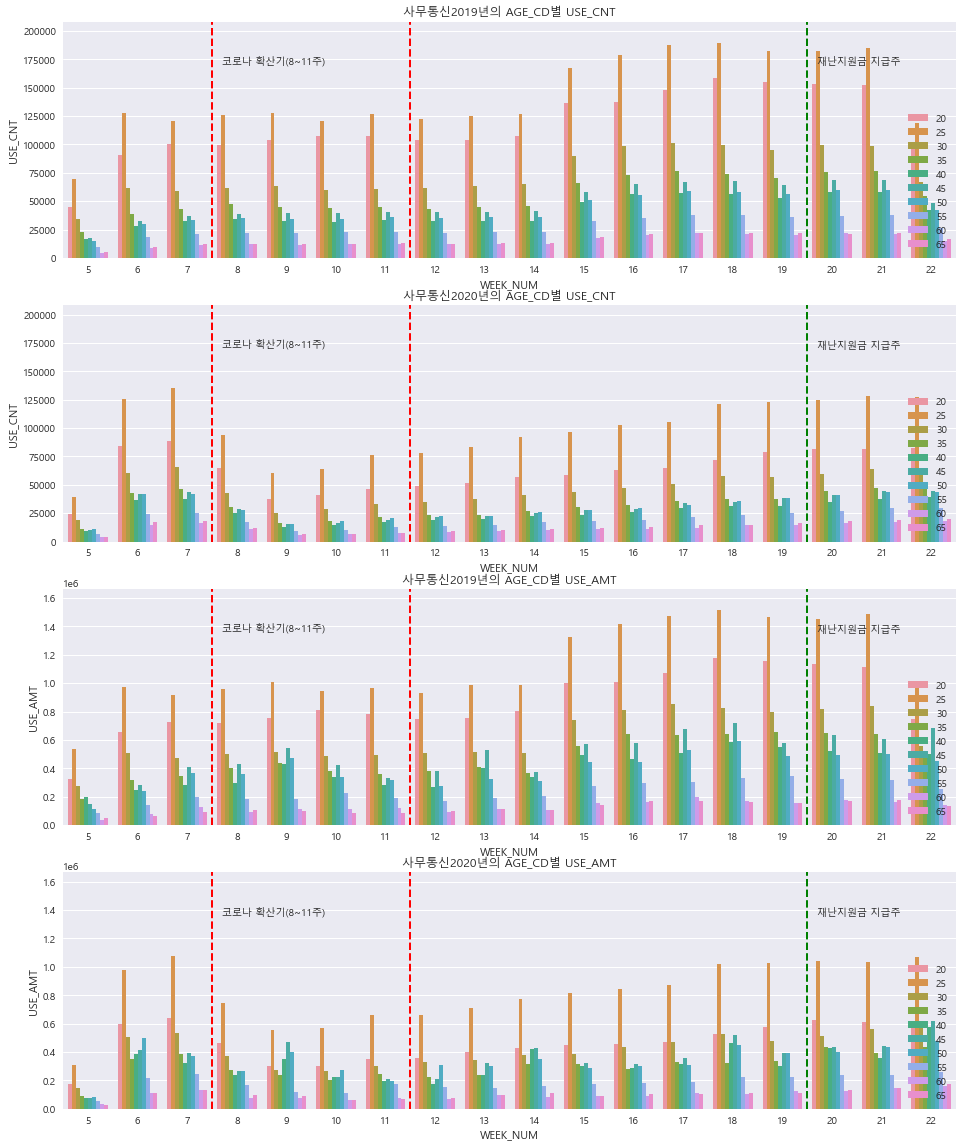

In [21]:
graph_by_month_number_offline("사무통신", "AGE_CD")

### (3) 19년과 20년의 요일별 비중 변화

In [22]:
def graph_by_weekday_offline(category_name, hue_column):
    # 카테고리에 해당하는 데이터 뽑기
    category_df = offline.loc[offline['MCT_CAT_CD']==category_name, :]
    # 년도 + 요일별로 CNT, AMT 합 구하기
    category_df = category_df.groupby(['YEAR', 'WEEKDAY', hue_column])[['USE_CNT', 'USE_AMT']].sum().reset_index()
    df_2019 = category_df.query('YEAR==2019')
    df_2020 = category_df.query('YEAR==2020')
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
    sns.barplot(x=hue_column, y='USE_CNT', hue='WEEKDAY', data=df_2019, ax=axes[0][0])
    sns.barplot(x=hue_column, y='USE_CNT', hue='WEEKDAY', data=df_2020, ax=axes[0][1])
    sns.barplot(x=hue_column, y='USE_AMT', hue='WEEKDAY', data=df_2019, ax=axes[1][0])
    sns.barplot(x=hue_column, y='USE_AMT', hue='WEEKDAY', data=df_2020, ax=axes[1][1])
    
    aggregate_columns = ['USE_CNT', 'USE_AMT']
    years = [2019, 2020]
    for i in [0, 1]:
        for j in [0, 1]:
            axes[i][j].set_ylim([0, df_2019[aggregate_columns[i]].max()*1.1])
            axes[i][j].set_title("{}년 요일별 {}".format(years[j], aggregate_columns[i]))

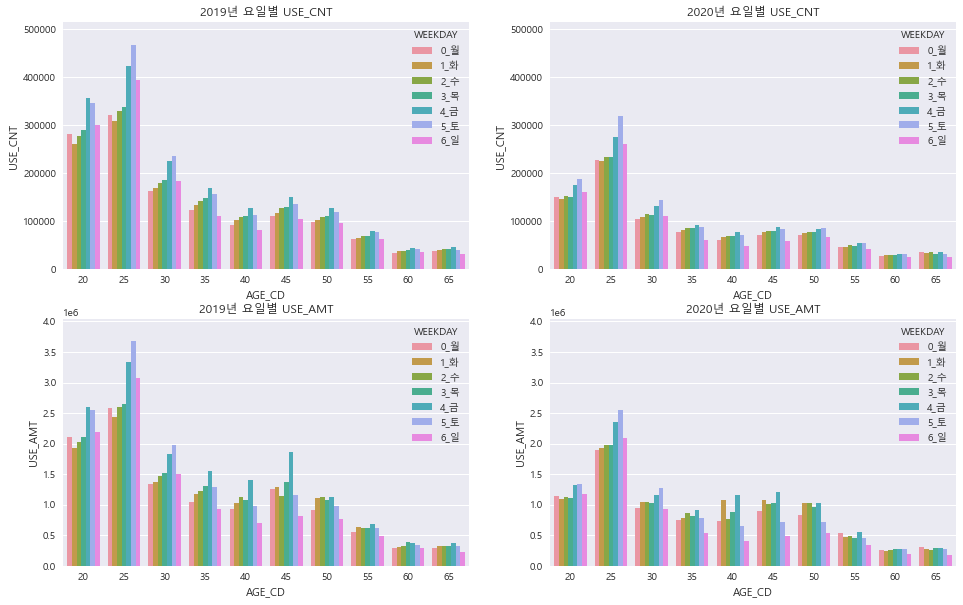

In [23]:
graph_by_weekday_offline("사무통신", "AGE_CD")

## 2. 성별 별로 시간에 따른 변화율 관찰

### (1) 19년과 20년의 월별 비중 변화

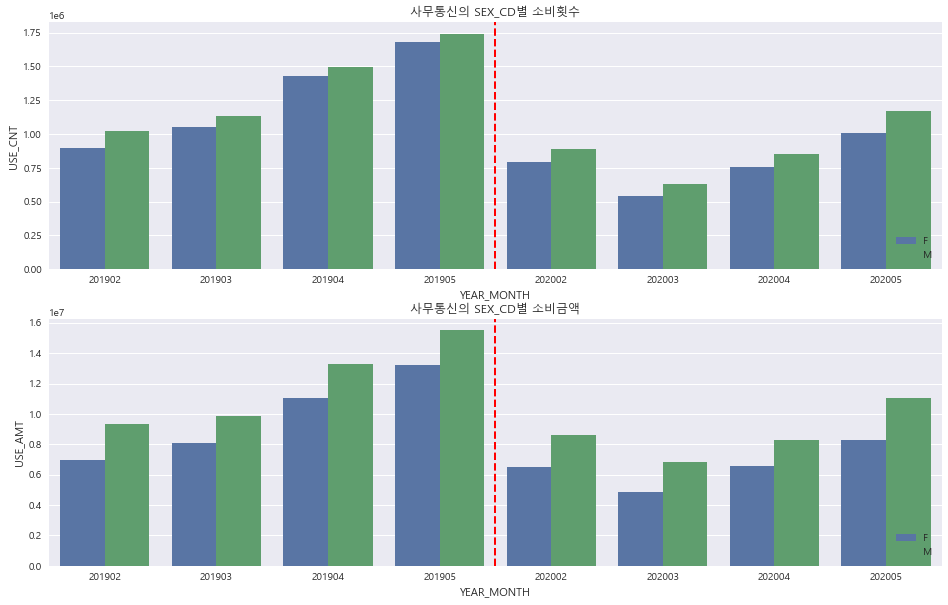

In [25]:
graph_by_year_month_offline("사무통신", "SEX_CD")

### (2) 19년과 20년의 주별 비중 변화

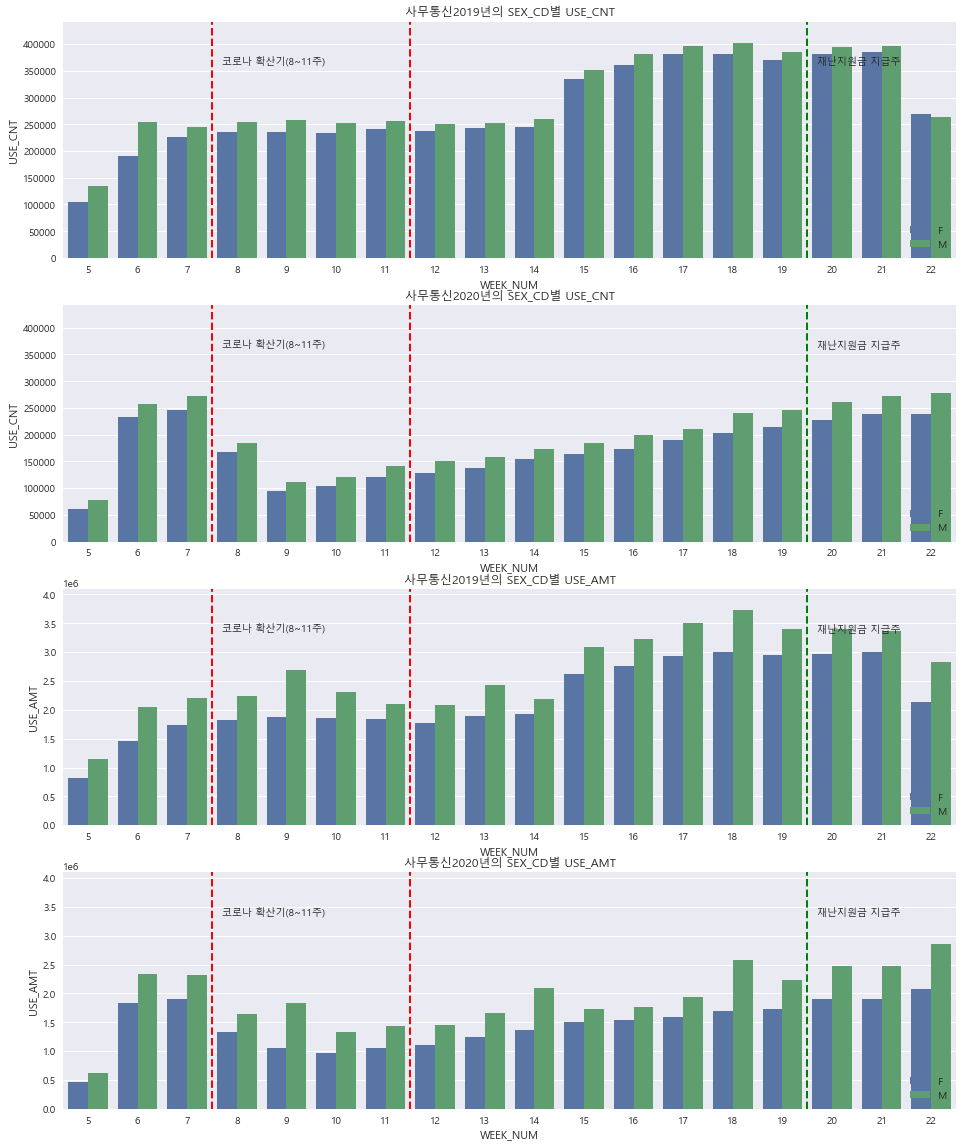

In [27]:
graph_by_month_number_offline("사무통신", "SEX_CD")

### (3) 19년과 20년의 요일별 비중 변화

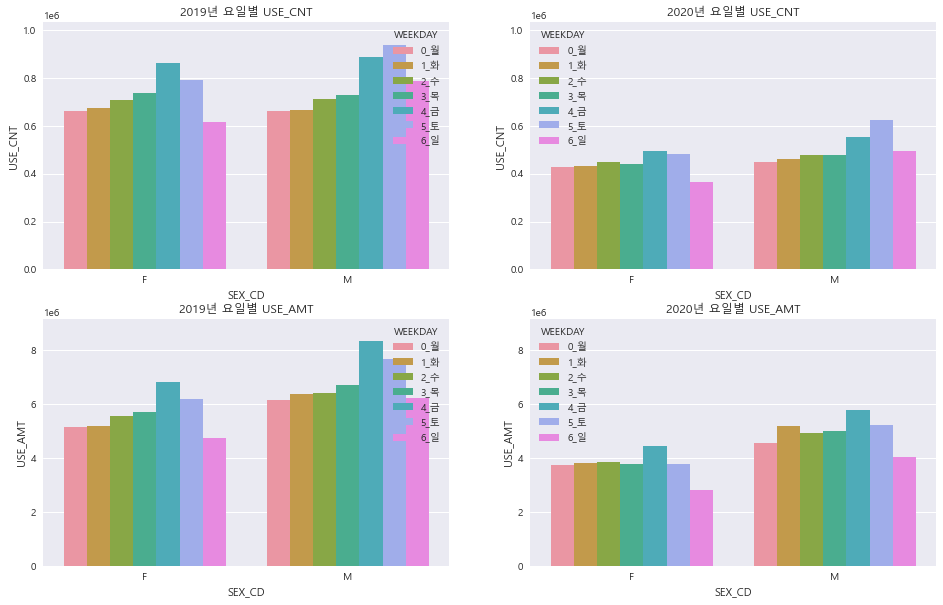

In [28]:
graph_by_weekday_offline("사무통신", "SEX_CD")

## 3. 전체적인 주차별 흐름 관찰

In [78]:
def graph_by_weeknum_offline(category_name, aggregate_column):
    # 지역별 주별 평균을 구하고 -> 이것을 업종별로 합해서 그 업종 추이를 보고자 하였다
    week_df = offline.groupby(['MCT_CAT_CD', 'GU_CD', 'DONG_CD', 'YEAR', 'WEEK_NUM', 'SEX_CD', 'AGE_CD'])[[aggregate_column]].mean().reset_index()
    week_df = week_df.groupby(['MCT_CAT_CD', 'YEAR', 'WEEK_NUM'])[[aggregate_column]].sum().reset_index()
    week_df = week_df.loc[week_df['MCT_CAT_CD']==category_name, :]
    
    max_date_num_week = datetime(2020, 3, 1).isocalendar()[1]
    disaster_support_date_num_week = datetime(2020, 5, 13).isocalendar()[1]

    plt.figure(figsize=(16, 5))
    ax = sns.lineplot(x='WEEK_NUM', y=aggregate_column, hue='YEAR', data=week_df, palette="Set2")
    ax.set_xticks([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
    ax.legend([2019, 2020])
    ax.axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
    ax.axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
    ax.set_ylim([0, week_df[aggregate_column].max()*1.1])
    ax.text(x=max_date_num_week, 
         y=week_df.query('YEAR==2020')[aggregate_column].min(), 
         s='　코로나 신규 확진자수 최고\n　(2020.03.01)',
         fontsize=12)
    ax.text(x=disaster_support_date_num_week, 
         y=week_df.query('YEAR==2020')[aggregate_column].min(), 
         s='　재난지원금\n　(2020.05.13)',
         fontsize=12)
    ax.set_title("주차별 {} {}".format(category_name, aggregate_column.upper()), fontsize=12)
    
    
def graph_by_weeknum_with_hue_offline(category_name, aggregate_column, hue_column):
    week_df = offline.groupby(['MCT_CAT_CD', 'GU_CD', 'DONG_CD', 'YEAR', 'WEEK_NUM', 'SEX_CD', 'AGE_CD'])[[aggregate_column]].mean().reset_index()
    week_df = week_df.groupby(['MCT_CAT_CD', 'YEAR', 'WEEK_NUM', hue_column])[[aggregate_column]].sum().reset_index()
    week_df = week_df.loc[week_df['MCT_CAT_CD']==category_name, :]
    
    max_date_num_week = datetime(2020, 3, 1).isocalendar()[1]
    disaster_support_date_num_week = datetime(2020, 5, 13).isocalendar()[1]

    year_2019_df = week_df.loc[week_df['YEAR']==2019, :]
    year_2020_df = week_df.loc[week_df['YEAR']==2020, :]

    max_date_num_week = datetime(2020, 3, 1).isocalendar()[1]
    disaster_support_date_num_week = datetime(2020, 5, 13).isocalendar()[1]
    hue_columns = list(set(week_df[hue_column]))
    hue_columns.sort()
    len_rows = len(set(week_df[hue_column]))

    fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
    sns.lineplot(x='WEEK_NUM', y=aggregate_column, hue=hue_column, data=year_2019_df, palette="Set2", ax=axes[0])
    sns.lineplot(x='WEEK_NUM', y=aggregate_column, hue=hue_column, data=year_2020_df, palette="Set2", ax=axes[1])
    for i in [0, 1]:
        year = 2019 if i==0 else 2020
        axes[i].set_ylim([0, week_df[aggregate_column].max()*1.1])
        axes[i].legend(loc='lower left')
        axes[i].set_xticks(list(set(week_df['WEEK_NUM'])))
        axes[i].axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
        axes[i].set_title("{}년도".format(year))

    fig, axes = plt.subplots(nrows=len_rows, figsize=(16, 5*len_rows))
    for i, select in enumerate(hue_columns):
        temp_2019 = year_2019_df.loc[year_2019_df[hue_column]==select, :]
        temp_2020 = year_2020_df.loc[year_2020_df[hue_column]==select, :]

        sns.lineplot(x='WEEK_NUM', y=aggregate_column, data=temp_2019, ax=axes[i], palette='Set2')
        sns.lineplot(x='WEEK_NUM', y=aggregate_column, data=temp_2020, ax=axes[i], palette='Set2')
        axes[i].set_ylim(0, max([temp_2019[aggregate_column].max(), temp_2020[aggregate_column].max()])*1.1)
        axes[i].set_xticks(list(set(week_df['WEEK_NUM'])))
        axes[i].legend([2019, 2020], loc='upper left')
        axes[i].axvline(x=max_date_num_week, color='r', linewidth=2, linestyle='--')
        axes[i].axvline(x=disaster_support_date_num_week, color='g', linewidth=2, linestyle='--')
        axes[i].set_title(select)
        axes[i].text(x=max_date_num_week, 
                     y=min([temp_2019[aggregate_column].min(), temp_2020[aggregate_column].min()]), 
                     s='　코로나 신규 확진자수 최고\n　(2020.03.01)',
                     fontsize=12)
        axes[i].text(x=disaster_support_date_num_week, 
                     y=min([temp_2019[aggregate_column].min(), temp_2020[aggregate_column].min()]), 
                     s='　재난지원금\n　(2020.05.13)',
                     fontsize=12)

    plt.show()

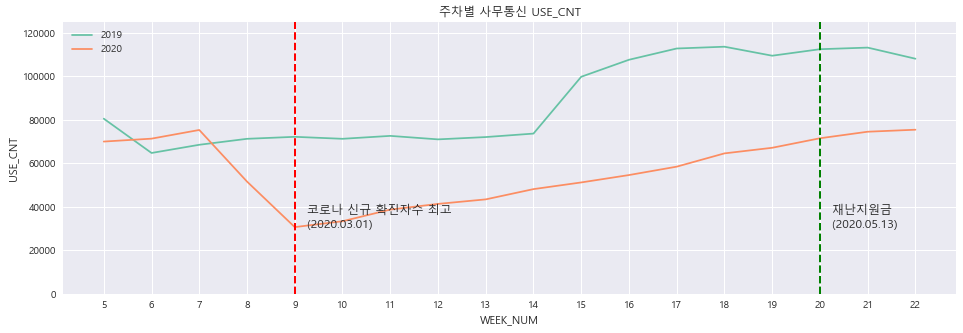

In [79]:
graph_by_weeknum_offline("사무통신", "USE_CNT")

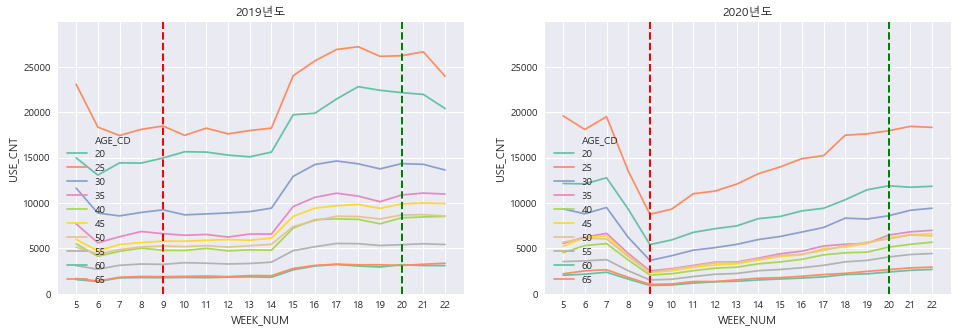

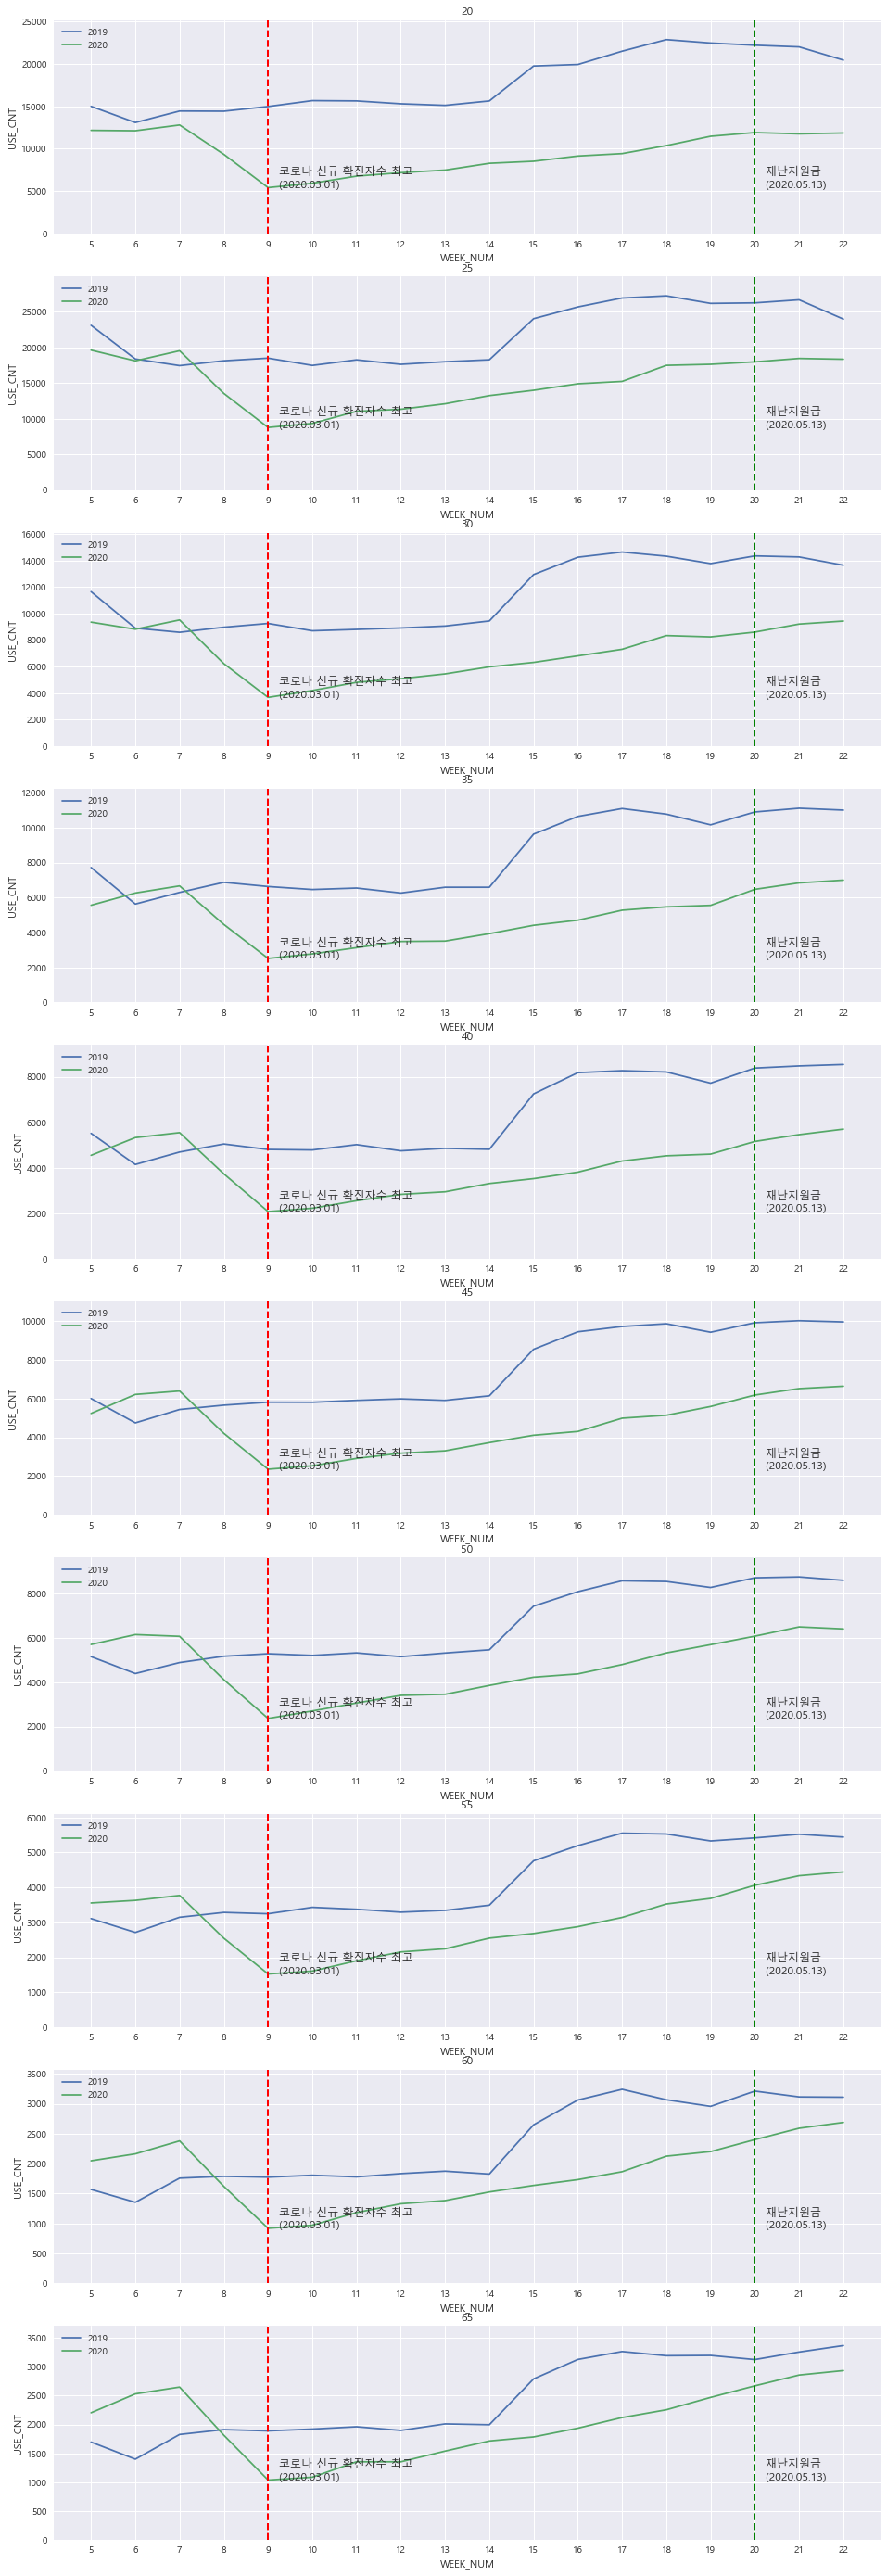

In [81]:
graph_by_weeknum_with_hue_offline("사무통신", "USE_CNT", "AGE_CD")

# Risk Index

In [262]:
def risk_index(df, group_col='MCT_CAT_CD', val='USE_CNT'):
    cat_list = df[group_col].unique().tolist()
    impact_index_dict = {}
    
    for cat in cat_list:
        tmp_df = df.loc[offline[group_col]== cat]
        
        tmp_2019 = tmp_df.query('YEAR==2019').reset_index(drop=True)
        tmp_2020 = tmp_df.query('YEAR==2020').reset_index(drop=True)
        tmp_2019 = tmp_2019.groupby(['STD_DD','YEAR','MONTH', 'DAY', 'WEEK_NUM','WEEKDAY'])[val].sum().reset_index()
        tmp_2020 = tmp_2020.groupby(['STD_DD','YEAR','MONTH', 'DAY', 'WEEK_NUM','WEEKDAY'])[val].sum().reset_index()
        
        ### 코로나 터지기 2주전 시점의 평균
        pre_2019 = tmp_2019.iloc[7:21,6].mean()
        pre_2020 = tmp_2020.iloc[6:20,6].mean()
        
        ### 이동 평균선 (7일) 구하기
        tmp_2019['USE_CNT'] = round(tmp_2019['USE_CNT'].rolling(window=7, center = True).mean(),2)
        tmp_2020['USE_CNT'] = round(tmp_2020['USE_CNT'].rolling(window=7, center = True).mean(),2)
        
        ### 두 데이터프레임의 index 맞추기.
        tmp_2019 = tmp_2019.loc[tmp_2019['WEEK_NUM']>6, ]
        tmp_2019 = tmp_2019.loc[tmp_2019['WEEK_NUM']<22, ].reset_index(drop = True)
        tmp_2020 = tmp_2020.loc[tmp_2020['WEEK_NUM']>6, ]
        tmp_2020 = tmp_2020.loc[tmp_2020['WEEK_NUM']<22, ].reset_index(drop = True)
        
        ### 가장 낮아진 시점 구하기.
        T = np.argmin(tmp_2020['USE_CNT'])
        min_2020 = tmp_2020.iloc[np.argmin(tmp_2020['USE_CNT']), 6]
        
        ### Impact index 계산
        post_2020 = tmp_2020.iloc[T, 6]
        r1 = (pre_2020 - post_2020) / pre_2020
        print("2020년에 코로나 터지기 전 평균: {}, 터진 후 최소: {} -> r1 = {}".format(pre_2020, post_2020, r1))
        post_2019 = tmp_2019.iloc[T, 6]
        r2 = (pre_2019 - post_2019) / pre_2019
        print("2019년에 코로나 터지기 전 평균: {}, 터진 후 최소: {} -> r2 = {}".format(pre_2019, post_2019, r2))
        impact_index = ((r1 - r2)/abs(r2)) ** 0.5
        print("{} 업종의 Impact index = {}".format(cat,impact_index))
   
        impact_index_dict[cat] = impact_index

    return  impact_index_dict

In [263]:
risk_index_dict = risk_index(offline, group_col='MCT_CAT_CD', val='USE_CNT')
risk_index_dict

2020년에 코로나 터지기 전 평균: 3697.785714285714, 터진 후 최소: 2141.57 -> r1 = 0.42085070215766185
2019년에 코로나 터지기 전 평균: 4273.714285714285, 터진 후 최소: 4165.0 -> r2 = 0.025437892766412534
숙박 업종의 Impact index = 3.94261891351079
2020년에 코로나 터지기 전 평균: 7903.428571428572, 터진 후 최소: 3977.0 -> r1 = 0.49680066517243876
2019년에 코로나 터지기 전 평균: 10064.714285714286, 터진 후 최소: 15364.71 -> r2 = -0.5265917704001247
레저용품 업종의 Impact index = 1.3940683502348212
2020년에 코로나 터지기 전 평균: 25409.214285714286, 터진 후 최소: 14763.29 -> r1 = 0.4189788856123622
2019년에 코로나 터지기 전 평균: 22706.714285714286, 터진 후 최소: 21201.14 -> r2 = 0.06630524640288905
레저업소 업종의 Impact index = 2.3062827622784963
2020년에 코로나 터지기 전 평균: 42.92857142857143, 터진 후 최소: 30.43 -> r1 = 0.2911480865224626
2019년에 코로나 터지기 전 평균: 48.285714285714285, 터진 후 최소: 35.86 -> r2 = 0.25733727810650886
전기 업종의 Impact index = 0.36247363736637467
2020년에 코로나 터지기 전 평균: 447.35714285714283, 터진 후 최소: 271.29 -> r1 = 0.39357177071690874
2019년에 코로나 터지기 전 평균: 502.07142857142856, 터진 후 최소: 561.86 -> r2 = -0.

{'숙박': 3.94261891351079,
 '레저용품': 1.3940683502348212,
 '레저업소': 2.3062827622784963,
 '전기': 0.36247363736637467,
 '주방용구': 2.0748490398449015,
 '연료판매': 6.531971188464399,
 '광학제품': 1.7458996440823054,
 '유통업': 1.4935849389377738,
 '사무통신': 3.3681945836402574,
 '자동차 정비': 2.0612277838315443,
 '의료기관': 0.7767816227638227,
 '보건위생': 2.1745091562895995,
 '요식업소': 2.391536170365712,
 '음료식품': 1.548216182400715,
 '수리서비스': 1.974011915923699,
 '문화취미': 2.4664339852723707,
 '가구': 2.332125698559176,
 '가전': 2.7917550636697728,
 '의복': 1.7306757225582667,
 '신변잡화': 1.9123072603902078,
 '서적문구': 1.6402158921922434,
 '직물': 2.2413306008031912,
 '자동차판매': 1.886623671961483}

In [132]:
r_list = tmp_2020['USE_CNT'] / tmp_2019['USE_CNT']
r_list

0      1.207715
1      1.512633
2      1.137349
3      0.974390
4      0.980797
         ...   
107    1.005514
108    1.023254
109    0.984172
110    0.945666
111    0.907830
Name: USE_CNT, Length: 112, dtype: float64

In [134]:
r_list[T-14:T].mean()

0.7673608633532877

STD_DD      2020-05-22 00:00:00
YEAR                       2020
MONTH                         5
DAY                          22
WEEK_NUM                     21
WEEKDAY                     4_금
USE_CNT                  553028
Name: 111, dtype: object